In [359]:
# Import Python driver
import neo4j
from neo4j import GraphDatabase
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import networkx.algorithms.community as nx_comm

## Analyse eines Netzwerks von Terroristen

Als Datenbasis dient ein Netzwerk von Terroristen, das im Nachgang des Anschlags auf das World Trade Center am 11.09.2001 rekonstruiert wurde.

 **Node Labels des Netzwerks**
-  **Person**: Terroristen (Anzahl 60)
-  **Group**: Terroristengruppen (Anzahl 5)

 **Relationships des Netzwerks**
-  **Person [:KNOWS] Person**: Bekanntschaft zwischen Terroristen (Anzahl 302)
-  **Person [:PART_OF] Group**: Zuordnung zwischen Terrorist und dessen Gruppe (Anzahl 60)

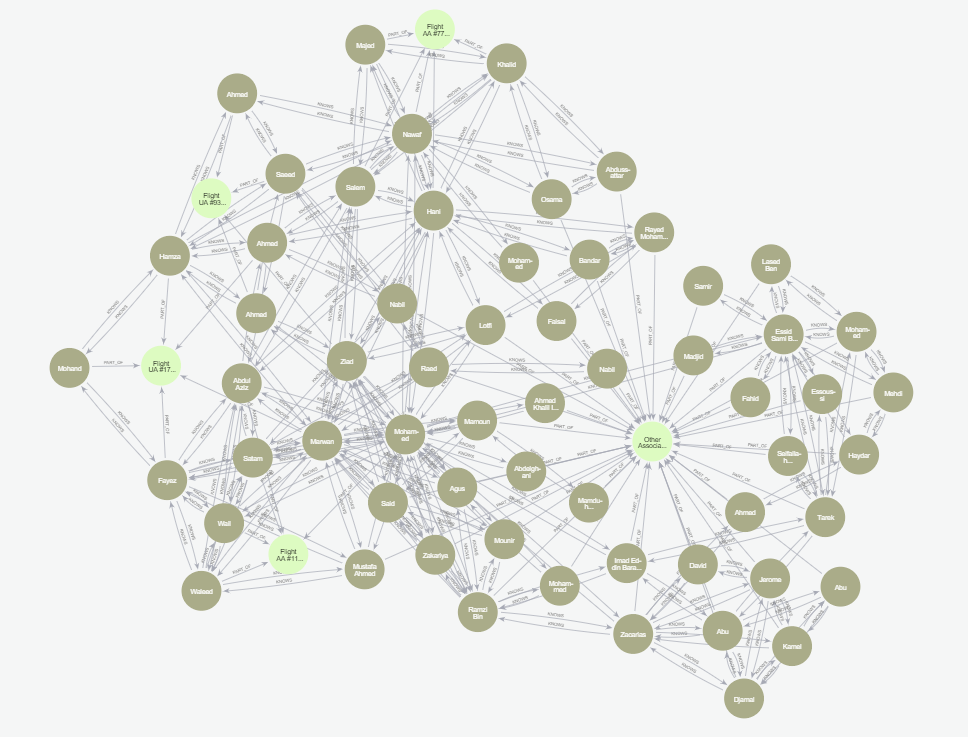

### Aufgabe 1
Verbinde dich mit dem Python Client auf die Neo4j AuraDB und ermittle mit einer Cypher-Query die Anzahl der Terroristen, die mit Flug AA #11 in das WTC North geflogen sind (Terroristengruppe mit groupid=1).

In [320]:
# Connection properties
URI = "neo4j+s://35049ef8.databases.neo4j.io"
AUTH = ("neo4j", "jTXJ9PTZv7QDy1Z6PIf3DzhlGzJeUyFZYqqoil5rhVw")

# Connect to DB and execute query
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()
    records, summary, keys = driver.execute_query("""
                                       MATCH (p:Person)-[:PART_OF]->(g:Group {groupid:'1'})
                                       RETURN count(p) as number
                                       """,
                                       database_="neo4j",)
    
print("Anzahl Terroristen:" , records[0]['number'])

Anzahl Terroristen: 5


### Aufgabe 2
Lese alle Terroristen-Nodes inkl. aller Properties aus dem Neo4j-Graphen aus und überführe ihn in einen gerichteten NetworkX Graphen.

Added  60 Nodes to the Graph.
Added  302 Edges to the Graph.


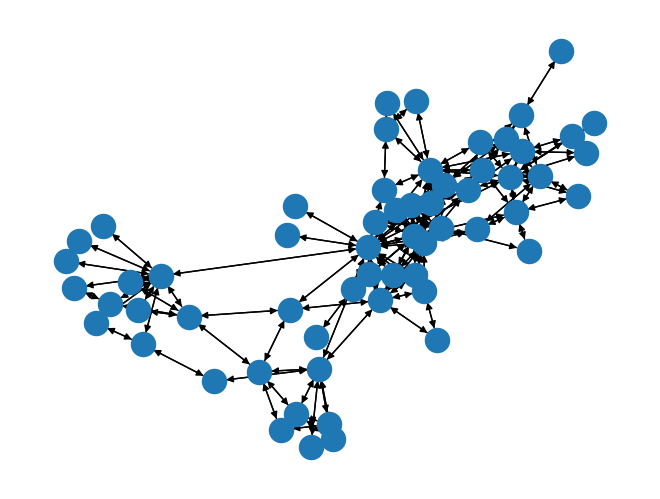

In [321]:
# Connect to DB and execute query
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()
    graph_result = driver.execute_query("""  
                                                MATCH p=()-[:KNOWS]->()
                                                RETURN *
                                                """,
                                                database_="neo4j",
                                                result_transformer_=neo4j.Result.graph
                                                )

# Create NetworkX Graph
G = nx.DiGraph()


for node in graph_result.nodes:
    G.add_node(node.element_id)
    nx.set_node_attributes(G, {node.element_id: node._properties})

for rel in graph_result.relationships:
    G.add_edge(rel.start_node.element_id, rel.end_node.element_id)
    
print("Added ", len(G.nodes()), "Nodes to the Graph.")
print("Added ", len(G.edges()), "Edges to the Graph.")

# draw the directed graph G
nx.draw(G)

### Aufgabe 3
Konvertiere den gerichteten Graphen in einen ungerichteten Graphen. Prüfe die Anzahl der Knoten und Kanten des resultierenden Graphen. Visualisiere anschließend das Netzwerk mit Bezeichnungen der Knoten.

Anzahl Nodes:  60
Anzahl Edges:  151


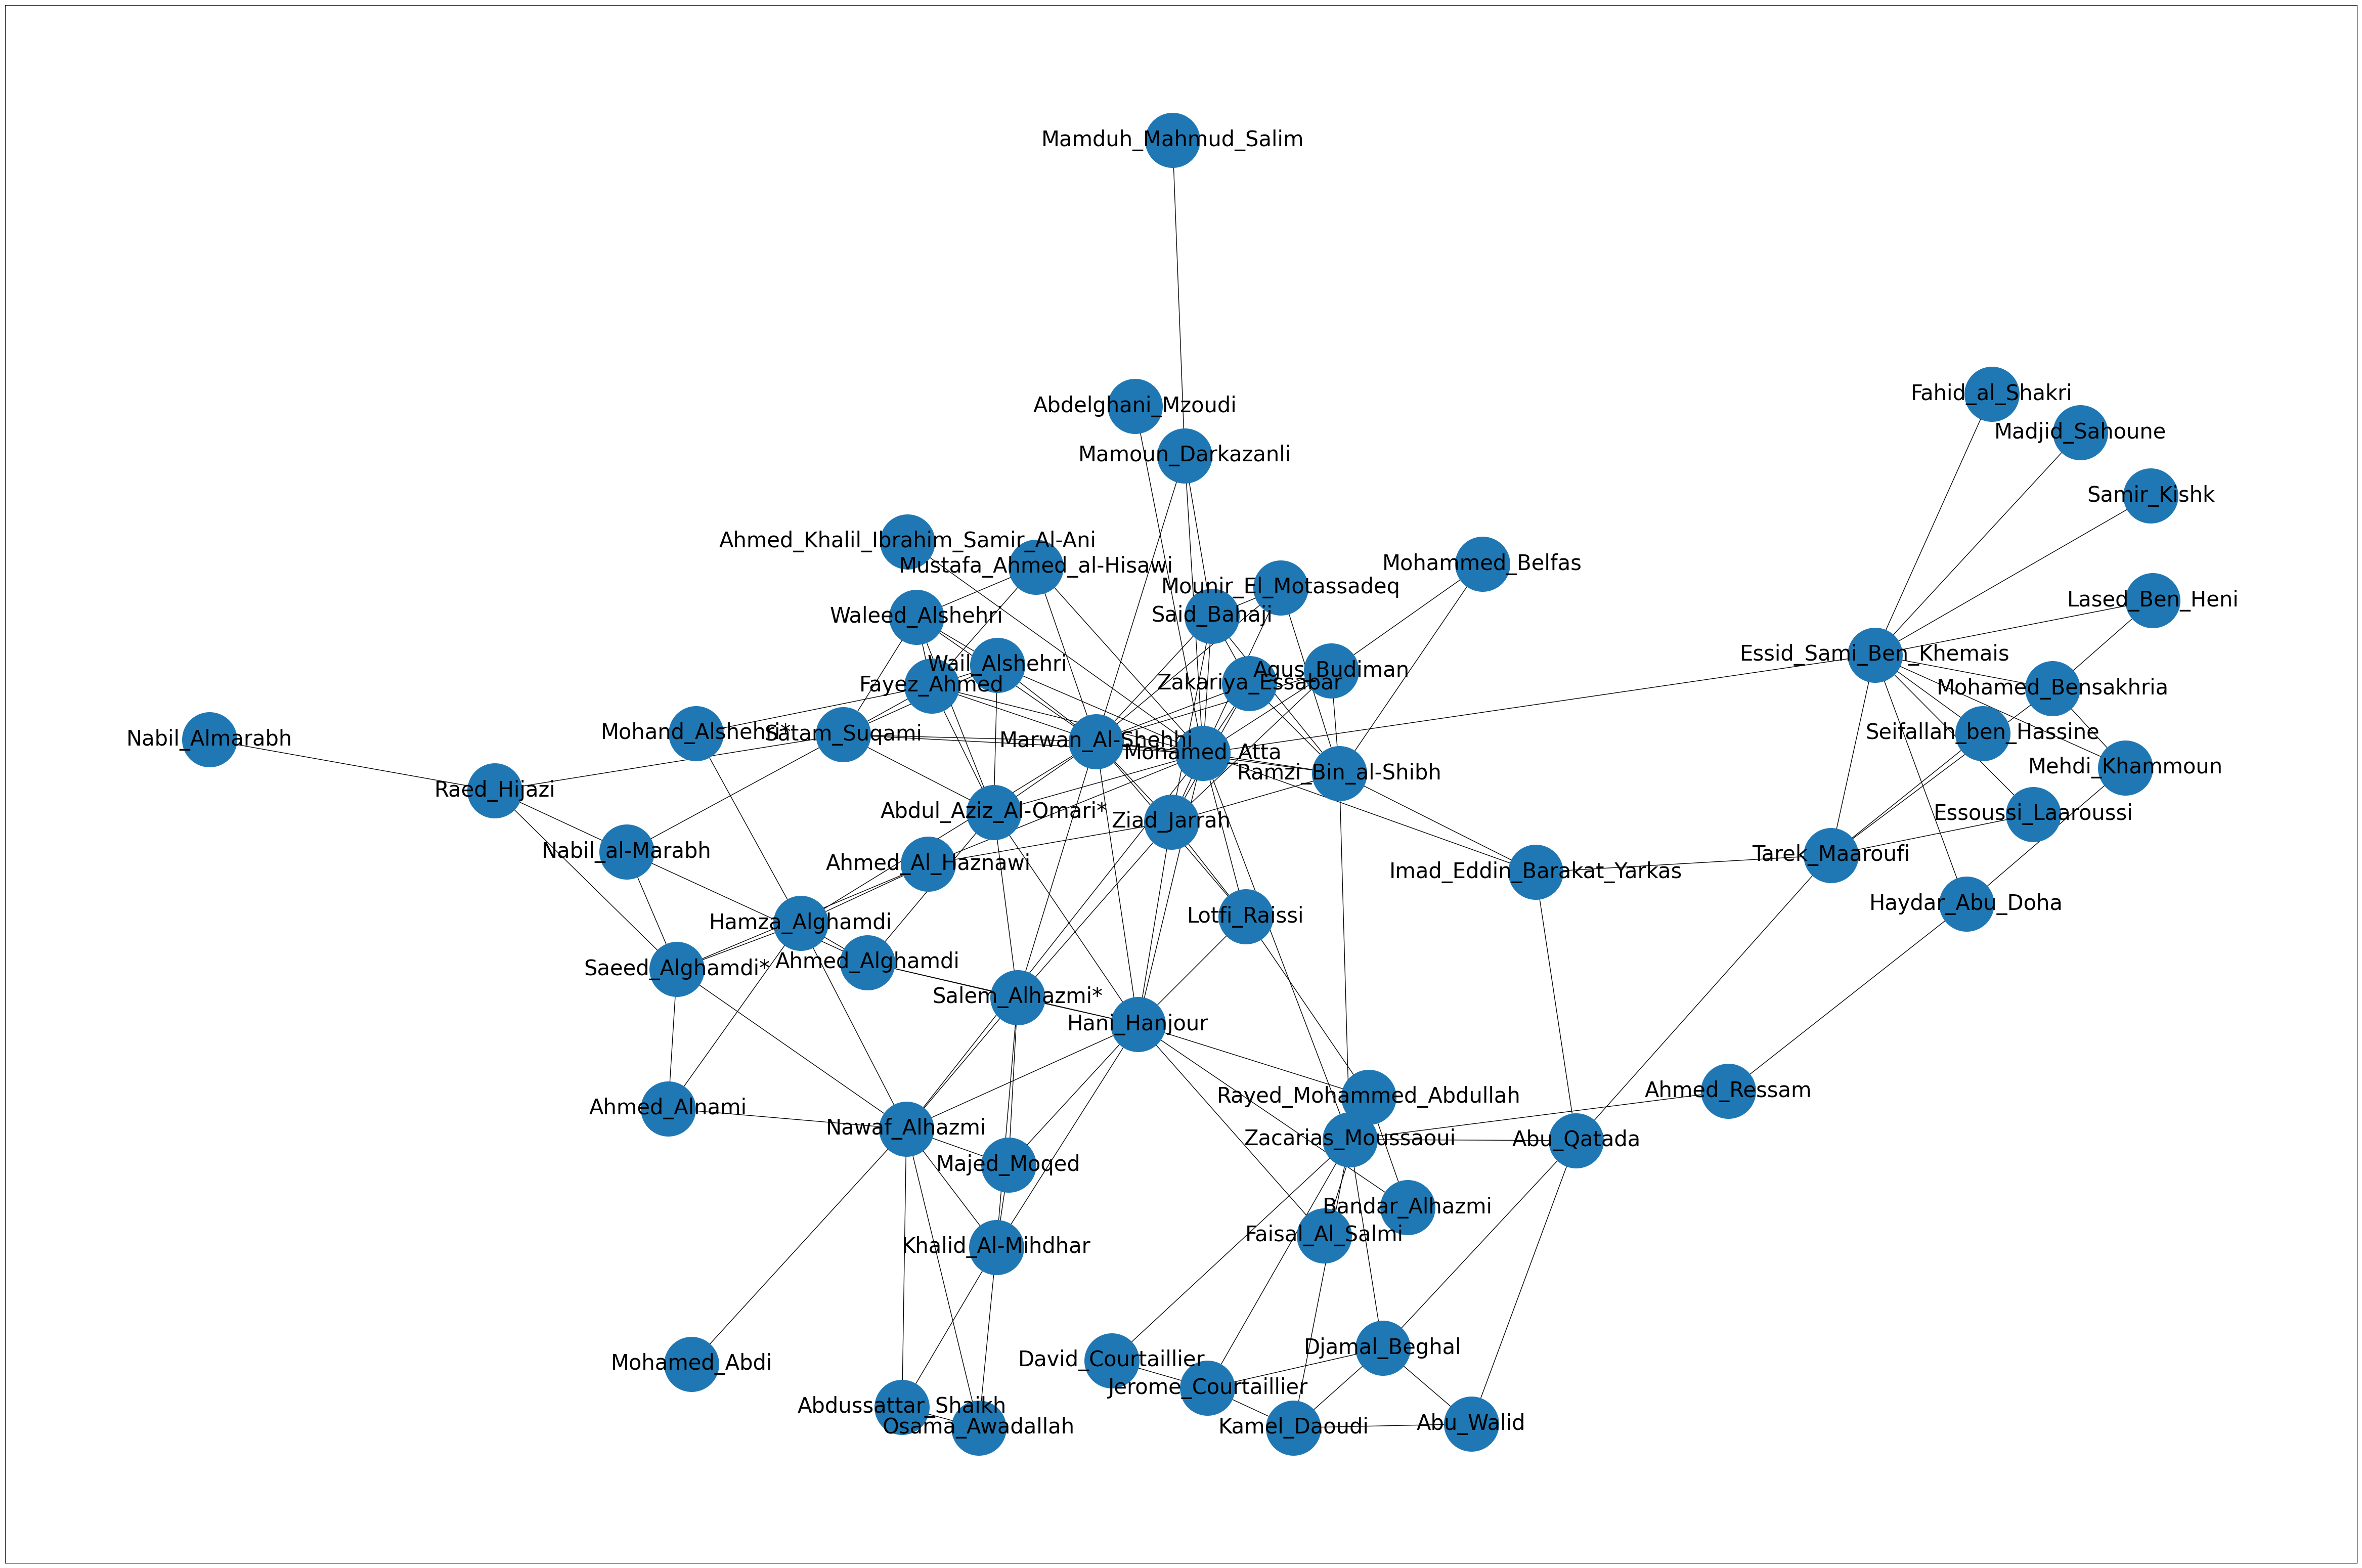

In [323]:
# convert to undirected graph
G_911 = G.to_undirected()

# check number of nodes and edges
print("Anzahl Nodes: ", len(G_911.nodes()))
print("Anzahl Edges: ", len(G_911.edges()))

# draw the network G_911 with labels, and bigger size
plt.figure(figsize=(60, 40))
labels = nx.get_node_attributes(G_911, 'personid')
nx.draw_networkx(G_911, labels=labels, with_labels=True, node_size=6000, font_size=30)

### Aufgabe 4

Welche drei Terroristen im Netzwerk besitzen die höchste normierte Degree Centrality?

In [357]:
# calculate degree centralitiy of all nodes
deg_centralities = nx.degree_centrality(G_911)

# sort result dictionary descending by value and select top 3
top3 = sorted(deg_centralities.items(), key=lambda x: x[1], reverse=True)[0:3]

# print results
for n in top3:
    print("Node Label: ", n[0], ", Degree Centrality: ", n[1], ", Personid:", G_911.nodes[n[0]]['personid'])

Node Label:  4:5ff4ea48-12a5-4f94-9bf7-db9633f34ab6:40 , Degree Centrality:  0.3728813559322034 , Personid: Mohamed_Atta
Node Label:  4:5ff4ea48-12a5-4f94-9bf7-db9633f34ab6:37 , Degree Centrality:  0.3050847457627119 , Personid: Marwan_Al-Shehhi
Node Label:  4:5ff4ea48-12a5-4f94-9bf7-db9633f34ab6:25 , Degree Centrality:  0.22033898305084745 , Personid: Hani_Hanjour


### Aufgabe 5

Plotte die Degree Distribution des Netzwerks. Handelt es sich um ein skalenfreies Netzwerk? 

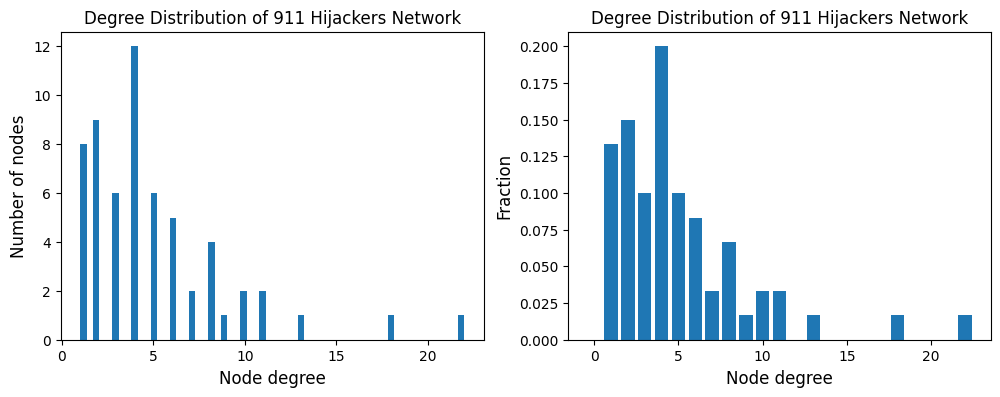

In [358]:
# Solution with subplots and different axis
def plot_degree_dist(G, title, fontsize):
    degrees = [G.degree(node) for node in G.nodes()]
    degree_hist = nx.degree_histogram(G)
    degrees_unique = range(len(degree_hist))
    degree_fraction = [d / nx.number_of_nodes(G) for d in degree_hist]
    
    plt.figure(figsize=(12,4))
    
    # Plot 1 with number of nodes on y axis
    plt.subplot(1,2,1)
    plt.hist(degrees, bins=G.number_of_nodes())
    plt.xlabel('Node degree', fontsize=fontsize)
    plt.ylabel('Number of nodes', fontsize=fontsize)
    plt.title(title)
    
    # Plot 2 with degree probability (fraction) on y axis
    plt.subplot(1,2,2)
    plt.bar(degrees_unique, degree_fraction)
    plt.xlabel('Node degree', fontsize=fontsize)
    plt.ylabel('Fraction', fontsize=fontsize)
    plt.title(title)

plot_degree_dist(G_911,'Degree Distribution of 911 Hijackers Network', fontsize=12)

### Aufgabe 6
Ermittle die Communities des Netzwerks mithilfe des **asynchronen** Label-Propagation-Algorithmus. Speichere die Community-Zuordnung in einem Node Attribut und visualiere anschliessend das Netzwerk mit farblicher Markierung der Communities.

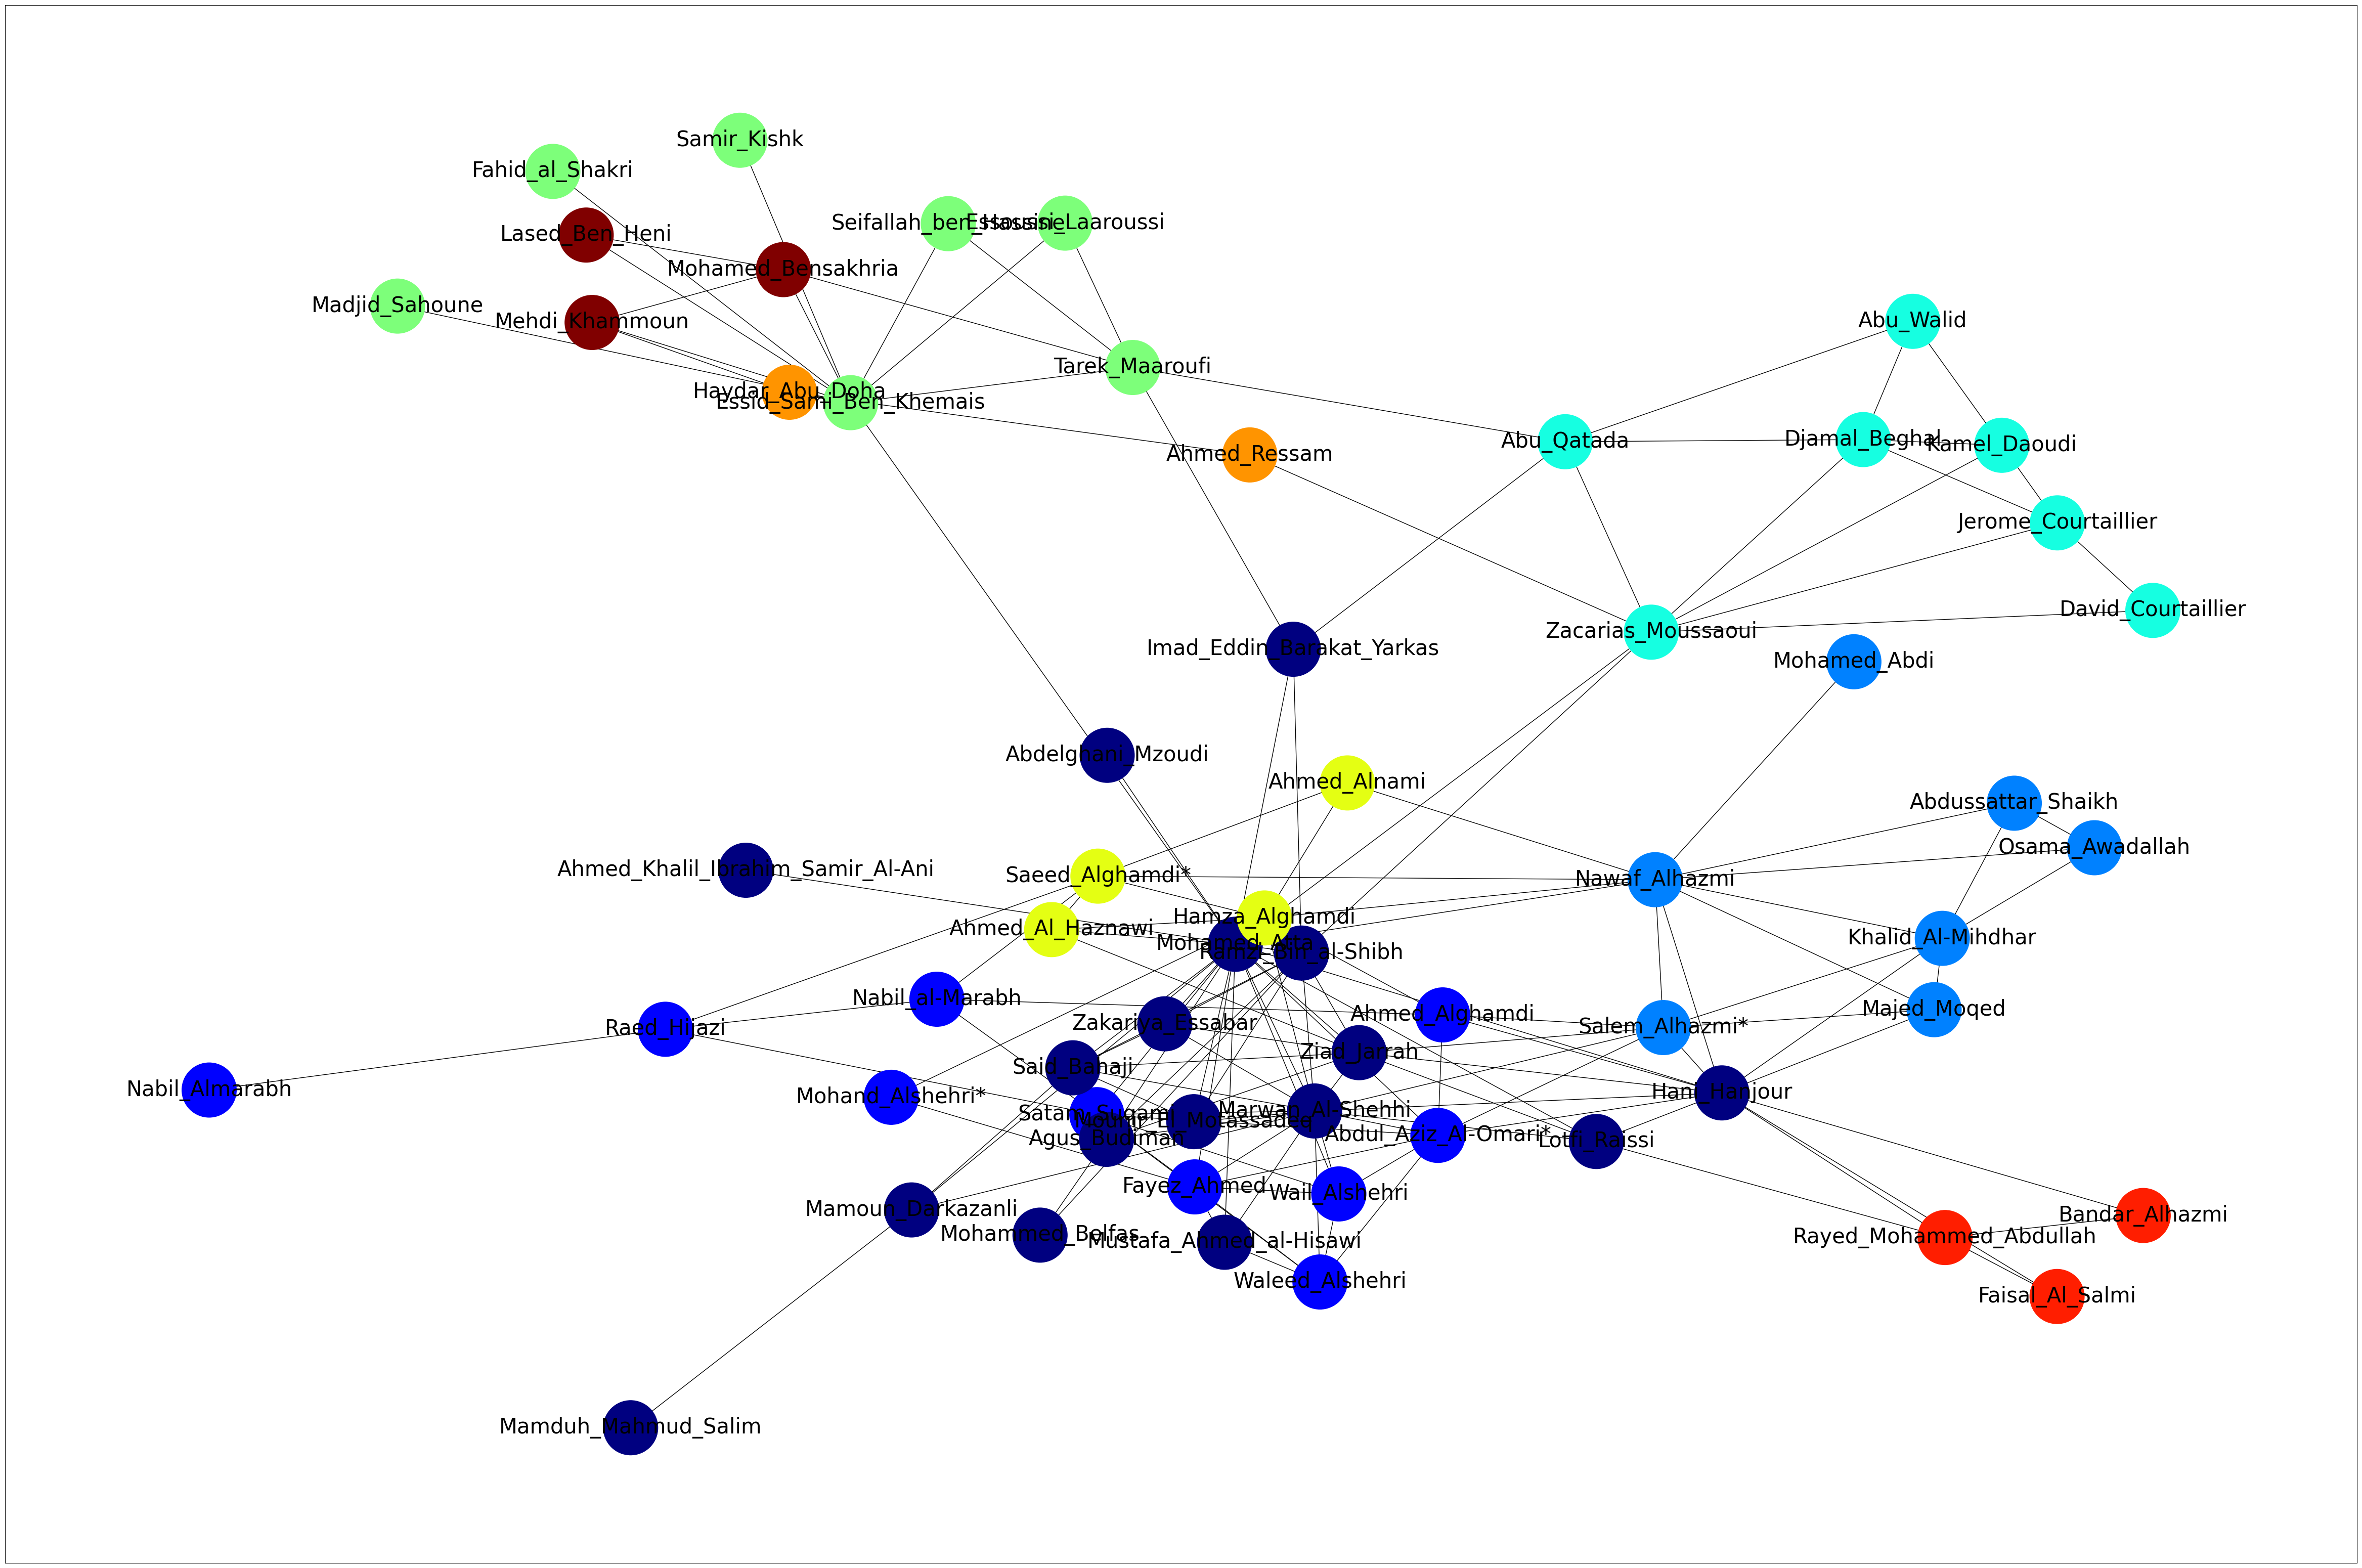

In [369]:
lpa_asyn_comm = list(nx_comm.asyn_lpa_communities(G_911, seed=1234))

for c in lpa_asyn_comm:
    for n in c:
        G_911.nodes[n]['lpa_asyn_comm'] = lpa_asyn_comm.index(c)


def plot_communities (node_attr_comm, graph):
    
    colors = [graph.nodes[node][node_attr_comm] for node in graph.nodes()]

    plt.figure(figsize=(60, 40))
    labels = nx.get_node_attributes(G_911, 'personid')
    nx.draw_networkx(graph, labels=labels, with_labels=True, node_size=6000, cmap = plt.get_cmap('jet'), node_color=colors, font_size=30)

plot_communities('lpa_asyn_comm', G_911)